# Exercise - Loan Agent - STARTER

In this exercise, you’ll build a Loan Agent Workflow using LangGraph, designed to negotiate loan amounts with customers.


**Scenario**


You're building an AI-powered loan recommendation agent for a fintech company. Based on customer profile data (such as name, income, credit history, etc.), your agent should return a structured recommendation.

This agent will be integrated into a larger pipeline of automated decision-making. To ensure everything works smoothly, it’s essential that the agent’s output strictly follows a predefined schema — no extra fields, no format deviations.


**Challenge**

You’re developing an AI-powered Loan agent.

The workflow should:

- Interpret user queries intelligently.
- Dynamically calls tools for loan calculation
- Track negotiation status and terminates gracefully.
- Route the workflow using intelligent conditional edges.

Your agent will calculate the maximum amount a customer can request based on their profile. If it exceeds, it will mark the status as lost and will explain the reason to the customer. If it meets, make as won, and notify the customer a human representative will contact them.

By the end of this exercise, you will have learned:
- Config
- Limiting Messages (RemoveMessages and summary)
- Command (Updating State from a Tool)
- Checkpoints (with thread_id)

## 0. Import the necessary libs

In [ ]:
import os
import re
import uuid
from typing_extensions import Literal, Annotated
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
    RemoveMessage
)
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langchain_core.runnables import RunnableConfig
from langgraph.graph.message import MessagesState, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.types import Command
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url = "https://openai.vocareum.com/v1",
    api_key = os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

## 2. Create the State Schema

Your state should have at least 3 elements:
- customer query, the user input to start the conversation
- messages, to keep track of the conversation
- negotiation status, to determine when to terminate the execution

Feel free to use TypedDict or MessagesState.

In [3]:
# TODO - State Schema called SessionState
class SessionState(MessagesState):
    customer_query: str
    negotiation_status: Literal["in_progress", "won", "lost"]


## 3. Define your Entrypoint node

This node should have the following responsibilities:
- Access all the configuration (RunnableConfig)
- Create the SystemMessage to instruct the agent
- Limit number of messages for each execution using summary and RemoveMessage
-  Create the HumanMessage based on the customer_query

In [4]:
# TODO - Define your function to summarize previous messages
def summarize_conversation(messages) -> AIMessage:
    """
    Summarize the conversation to keep the state clean.
    """

    summary_prompt = """
    Summarize the conversation between a loan agent and a customer.
    Include key details: loan amount requested, customer profile info mentioend, and current negotiation status.
    """

    conversation_text = "\n".join(
        f"{m.type}: {m.content}"
        for m in messages
        if hasattr(m, "content") and m.content
    )

    response = llm.invoke([
        HumanMessage(content= summary_prompt + "\n\n" + conversation_text)
    ])

    return AIMessage(
        content=f"Summary of previous conversation: {response.content}",
        name = "summary"
    )


In [5]:
# TODO - The entrypoint node
# An initial prompt is already created to help you
def entry_point(state: SessionState, config: RunnableConfig):
    """
    Entry point for the loan agent workflow.
    """

    # initialize messages list
    messages = state["messages"]

    # get customer details from config
    customer_name = config.get("configurable", {}).get("customer_name", "customer")
    age = config.get("configurable", {}).get("age", 18)
    income = config.get("configurable", {}).get("income", 1000)
    credit_score = config.get("configurable", {}).get("credit_score", 500)

    if not messages:
        prompt = (
            "You are a Loan Agent analysing a customer loan request.\n"
            "- Understand how much the customer needs.\n"
            "- Calculate the maximum loan amount using one of the provided tools.\n"
            "- If the requested amount exceeds the limit, update the negotiation to lost.\n"
            "- If the requested amount meets the limit, update the negotiation to won.\n"       
            "- Update status as won or lost based on the negotiation.\n"
            "Terminate gracefully:\n"
            "  - If won: Notify that a human representative will contact them.\n"
            "  - If lost: Thank the customer for their time and explain why the loan was refused.\n\n"
            "Details about the customer you're negotiating with:\n"
            f"- customer_name: {customer_name}"
            f"- customer_age: {age}"
            f"- customer_income: {income}"
            f"- customer_credit_score: {credit_score}"
        )

        # create system message
        sys_message = SystemMessage(
            content=prompt,
            name="system",
        )

        # add system message to messages list
        messages.append(sys_message)
    
    print(f"Number of messages {len(messages)}")

    # Filter Messages
    if len(messages)>=7:
        # TODO - use summarize_conversation and RemoveMessage 
        # create summary of previous conversation
        summary = summarize_conversation(messages)

        # mark old messages for removal
        messages_to_remove = [
            RemoveMessage(id = m.id)
            for m in messages[1:]
            if hasattr(m, 'id') and m.id != summary.id
        ]

        # add summary and remove messages to messages list
        messages = [
            messages[0],
            summary
        ] + messages_to_remove
        

    # create human message
    print(state["customer_query"])
    human_message = HumanMessage(
        content=state["customer_query"],
        name=re.sub(r'\s+', '_', customer_name.strip()).lower(),
        id = str(uuid.uuid4())
    )
    messages.append(human_message)

    return {
        "messages": messages,
        "negotiation_status": "in_progress",
    }
    

## 4. Define your tools

You need to create 2 tools:
- calculate_max_loan, this is important to check if the amount requested meets the maximum allowed by their profile
- update_negotiation_status, this will update the schema using Command

In [6]:
# TODO - Max Loan Tool
@tool
def calculate_max_loan(
        age: Annotated[int, "greater than 17"], 
        income: Annotated[int, "greater than 0"],  
        credit_score: Annotated[int, "between 0 and 1000"],
    ) -> int:
    """
    Calculate the maximum loan amount based on customer's age, income, and credit score.
    - Age: 25-60 gets the highest eligibility, outside this range reduces eligibility.
    - Income: Multiplied by a factor to determine base amount.
    - Credit Score: High score (700+) increases the amount by 20%.
    """
    # TODO - Your logic here

    # base loan amount from income
    base_amount = income * 5
    age_factor = 1.0
    credit_factor = 1.0

    # adjust for age factor
    if 25 <= age <= 60:
        # full eligibility
        age_factor = 1.0
    
    elif 18 <= age < 25:
        # 70% of base, younger and less credit history
        age_factor = 0.7
    
    elif age > 60:
        # 50% of base, older and shorter repayment window
        age_factor = 0.5

    # adjust for credit score
    if credit_score >= 700:
        # 20% bonus for good credit
        credit_factor = 1.2
    
    elif credit_score >= 500:
        # 10% bonus for average credit
        credit_factor = 1.0

    else:
        # 5% penalty for poor credit
        credit_factor = 0.6
    
    # round to nearest thousand
    return int(base_amount * age_factor * credit_factor / 1000) * 1000

In [7]:
@tool
def update_negotiation_status(
        status: Literal["won", "lost"],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
    """
    Updates the negotiation status of the workflow.
    - 'won': If the customer agrees to the loan terms.
    - 'lost': If the customer declines the loan terms.
    - Returns the updated status.
    """
    
    return Command(
        update={
            # update the state keys
            "negotiation_status": status,
            # update the message history
            "messages": [
                ToolMessage(
                    content="Successfully updated negotiation_status", 
                    tool_call_id=tool_call_id
                )
            ],
        }
    )

In [8]:
tools = [
    calculate_max_loan, 
    update_negotiation_status
]

## 5. Create your Loan Agent

Bind tools to the llm built above and create your agent with this llm.

In [9]:
# TODO - Bind the tools
llm_with_tools = llm.bind_tools(tools)

In [10]:
# TODO - Define your loan agent
def loan_agent(state: SessionState):

    messages = state["messages"]

    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

## 6. Create your Router function

If the status is 'won' or 'lost', it should proceed to END. Otherwise, if there's a tool call and it's in progress, it should proceed to the tool node called 'tools'.

In [11]:
def negotiation_router(state: SessionState):
    print(f"inside router status: {state['negotiation_status']}")
    if state["negotiation_status"] != "in_progress":
        return END

    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

## 7. Build, Compile and Visualize your Workflow

- Instantiate the StateGraph with the SessionState
- Add all the nodes you created
- Add your edges:
    - start -> entry point
    - entry point -> loan agent
    - loan agent -> [tools, end]
    - tools -> end

Make sure you use the router function in the conditional edge.

Also, use MemorySaver to compile your graph

In [12]:
# TODO - define the workflow and add nodes and edges
workflow = StateGraph(SessionState)

# add nodes
workflow.add_node("entry_point", entry_point)
workflow.add_node("loan_agent", loan_agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "loan_agent")
workflow.add_conditional_edges(
    "loan_agent",
    negotiation_router,
    ["tools", END]
)
workflow.add_edge("tools", "loan_agent")

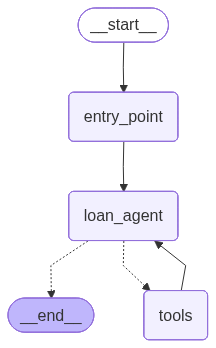

In [13]:
checkpointer = MemorySaver()
loan_graph = workflow.compile(checkpointer=checkpointer)

display(
    Image(
        loan_graph.get_graph().draw_mermaid_png()
    )
)

## 8. Invoke your Graph

Change the input and config and run execute it

In [14]:
customer_query = "I want to have $1000. Let me know if I qualify."

In [15]:
inputs = {
    "customer_query": customer_query,
}

config = {
    "thread_id": 2,
    "customer_name": "Henrique Fantana",
    "age": 34,
    "income": 1000,
    "credit_score": 750,
}

In [16]:
output = loan_graph.invoke(
    input=inputs,
    config=config,
)

output["messages"][-1].pretty_print()

Number of messages 1
I want to have $1000. Let me know if I qualify.
inside router status: in_progress
inside router status: in_progress
inside router status: won
================================== Ai Message ==================================

Congratulations, Henrique! You qualify for a loan amount of up to $6000. A human representative will contact you shortly to discuss the next steps. Thank you for choosing us!


## 9. Inspect it

After executing, inspect the outputs

In [17]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Henrique Fantana- customer_age: 34- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: henrique_fantana

I want to have $1000. Let me know if I qualify.
================================== Ai Message ==

In [18]:
output["negotiation_status"]

'won'

In [19]:
state_history = list(
    loan_graph.get_state_history(
        config={
            "configurable":{"thread_id":2}
        }
    )
)

In [20]:
state_history

[StateSnapshot(values={'messages': [SystemMessage(content="You are a Loan Agent analysing a customer loan request.\n- Understand how much the customer needs.\n- Calculate the maximum loan amount using one of the provided tools.\n- If the requested amount exceeds the limit, update the negotiation to lost.\n- If the requested amount meets the limit, update the negotiation to won.\n- Update status as won or lost based on the negotiation.\nTerminate gracefully:\n  - If won: Notify that a human representative will contact them.\n  - If lost: Thank the customer for their time and explain why the loan was refused.\n\nDetails about the customer you're negotiating with:\n- customer_name: Henrique Fantana- customer_age: 34- customer_income: 1000- customer_credit_score: 750", additional_kwargs={}, response_metadata={}, name='system', id='18187107-c3ea-4462-89db-00067c341f50'), HumanMessage(content='I want to have $1000. Let me know if I qualify.', additional_kwargs={}, response_metadata={}, name=

In [21]:
state_history[0].values["messages"][-1].content

'Congratulations, Henrique! You qualify for a loan amount of up to $6000. A human representative will contact you shortly to discuss the next steps. Thank you for choosing us!'

In [22]:
for m in state_history[0].values["messages"]:
    m.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Henrique Fantana- customer_age: 34- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: henrique_fantana

I want to have $1000. Let me know if I qualify.
================================== Ai Message ==

## 10. Experiment

Now that you understood how it works, experiment with new things.

- Run multiple times for the same thread_id, whant happens with the messages?
- Add a tool to calculate interests and taxes to enable pay in installments
- Improve negotiation, allowing the agent to offer discounts to close the deal